# Sentiment Classifier using feed-forward Neural Networks - GloVe features

The goal of this notebook is to develop a sentiment classifier using feed-forward neural networks for the Twitter sentiment analysis dataset. We are going to experiment and develop more than one models which use pre-traineed vectors as featues, and compare them over known metrics such as F1 score, Recall and Precision. 

We are going to expirement with parameters like:
 - Number of hidden layers
 - Activation functions
 - The loss function
 - The optimizer

 The data is going to be preprocessed and scaled, in order to maximize our classifier's potential.

 The classifier is going to be implemented using the PyTorch API

## Import Libraries

In [1]:
!python -m textblob.download_corpora
# For NN models
import torch.nn as nn
import torch
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
# For large and multi-dimensional arrays
import numpy as np
# For basic cleaning and data preprocessing 
import re
# For data manipulation and analysis
import pandas as pd
# Stop words
import nltk 
nltk.download('stopwords')  
# Data manipulation
import torchtext
from torchtext import data
# Data Preprocessing and Feature Engineering
from textblob import TextBlob
import scipy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Necessary for data format
from sklearn.feature_extraction.text import CountVectorizer
# Word embedings
from sklearn.feature_extraction.text import TfidfVectorizer  
# Machine learning model
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Best parameters during classification
from sklearn.model_selection import GridSearchCV
# Data preprocessing
from sklearn.model_selection import train_test_split
# Validation of the model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Configuration

We are going to import the dataset...

In [2]:
df = pd.read_csv("/content/drive/MyDrive/tn2/SentimentTweets.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1280000 non-null  int64 
 1   target      1280000 non-null  int64 
 2   id          1280000 non-null  int64 
 3   date        1280000 non-null  object
 4   flag        1280000 non-null  object
 5   user        1280000 non-null  object
 6   text        1280000 non-null  object
dtypes: int64(3), object(4)
memory usage: 68.4+ MB


...and take a look at its columns

In [3]:
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


## Data Preprocessing

Like the other notebook that we made,we have to preprocess our data set. We are going to convert everything to lowercase, and remove any punctuation points, weird characters and links.

We are going to classify tweets. As we all know, twitter users use the symbols `#` and `@` a lot. This may cause problem to the classifier, thus we are going to remove them, using `TextBlob`. We are also going to lemmatize the data in order to avoid multiple representations of the same word

In [4]:
def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove non alphanumeric character
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # remove links
    text = re.sub(r'https?:/\/\S+', ' ', text)
   
    return text

In [5]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.text = vfunc(input_df.text.values)
    # return processed input_df
    return input_df

Let's now apply those techniques in our dataset.

In [6]:
df = preprocess(df)
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,brokenpromises
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,david carradine so sad thai s law not sure if ...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,a 415 b 425 tell your bro i say congrats
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,littlefluffycat indeed
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,completed race 4 life in 58mins with girlies f...


We are going to convert the target value to 1 instead of 4, in order to be more convenient.

In [7]:
def change_to_1(x):
    if (x == 4):
        return 1
    else:
        return x

In [8]:
df['target'] = df['target'].apply(change_to_1)
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,brokenpromises
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,david carradine so sad thai s law not sure if ...
2,1337108,1,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,a 415 b 425 tell your bro i say congrats
3,1560887,1,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,littlefluffycat indeed
4,1466295,1,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,completed race 4 life in 58mins with girlies f...


We are now going to drop the columns we do not need, in order to save memory

In [9]:
df = df.drop(['Unnamed: 0', 'id', 'date', 'flag', 'user'], axis=1)

### Splitting the dataset

We are now going to split the dataset in order to have a dataset for training, one for validating, and one for testing our models

In [10]:
train_df, valid_df = train_test_split(df, train_size = .8, random_state = 42)
train_df, test_df = train_test_split(df, train_size = .25, random_state = 42)

## Feature extractions: Pre-Trained word vectors using `TorchText`

TorchText provides a handy API that allows as to handle a dataset in a way that PyTorch networks understand, while being able to apply techniques such as loading pretrained vectors, which is the goal of this notebook.

### Definition of dataset processing

We are going to define the columns that we want to process

In [11]:
TEXT = data.Field(tokenize = 'spacy', include_lengths=True)

LABEL = data.LabelField(dtype = torch.float)

# define which fiels we are going to process
train_val_fields = [
  ('text', TEXT), # process it as text
  ('target', LABEL) # process it as label
]

Next up, we are going create a class for splitting, because we have already loadad the dataset, thus the `TabularDataset.splits()` method is not convinient for us. The function returns the train and the validation dataset.

In [12]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False):
        examples = []
        # iterate all the rows in order to create the dataset dict
        for _, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields)

    # class method in order to return the dataset in an apropriate from
    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None):
        train_data, val_data, test_data = (None, None, None)

        train_data = cls(train_df.copy(), fields)
        val_data = cls(val_df.copy(), fields)
        test_data = cls(test_df.copy(), fields, True)


        return tuple(d for d in (train_data, val_data, test_data))

Now, we are going to use the class we created in order to convert our dataset in the appropriate type.

In [13]:
train_ds, val_ds, test_ds = DataFrameDataset.splits(train_val_fields, train_df=train_df, val_df=valid_df, test_df=test_df)

Let's print an item from the dataset, in order to observe its form

In [14]:
print(vars(train_ds[100]))

{'text': ['carpe', 'diem', 'quam', 'minimum', 'credula', 'postero', 'seize', 'the', 'day', 'and', 'place', 'no', 'trust', 'in', 'tommorow', 'new', 'motto', 'latin'], 'target': 1}


### Loading Pre-Trained vector embeddings

Next up, we are going to load the glove vectors in order to build our vocabulary that will be used in our model. We are going to define the maximum vocabulary size, getting the info from the TFIDF notebook, where our vocabulary length was 2000.

For every word that is not int the pretrained vectors' map, we are going to use values that are randomly distributed.

In [15]:
vocab_size = 20000
# build the vocabulary for both of the fields
TEXT.build_vocab(train_ds,  max_size = vocab_size, vectors = 'glove.6B.50d', unk_init=torch.Tensor.normal_)

LABEL.build_vocab(train_ds)

Another method to help as achieve our goal faster, is `BucketIterator`, a method that defines an iterator that batches examples of similar lenths together, in roder to minimise the necessary amount of padding during training

In [16]:
# preferebly use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create the 2 iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train_ds, val_ds), 
    batch_size = 128, device = device)

We are now all set in order to define our neural networks that will try to classify the available tweets as negative or positive. We will construct different models, that differ when it comes down to hyperparameters, and then evaluate them so we can conclude which is best.

## Model's definition

Let's now define the class of the model we are going to use. All of the models will be of the same architecture: 
 - 1 embedding layer
 - 1 hidden layer with RELU activation function
 - 1 output layer with sigmoid activation function

 We will later be expirementing with different hyperparameters

In [17]:
class Sentiment_Model(nn.Module):
  # init function
  def __init__(self, input_size, embedding_neurons, hidden_neurons):
    # initialization of mother class
    super(Sentiment_Model, self).__init__()

    # embedding layer: input -> embeding
    self.embedding = nn.Embedding(input_size, embedding_neurons)

    # 1st linear function: embeding -> hidden_neurons
    self.layer_1 = nn.Linear(embedding_neurons, hidden_neurons)
    # activation function for 1st layer
    self.relu_1 = nn.ReLU()

    # output layer: hidden_neurons -> 1 neuron (classification)
    self.output = nn.Linear(hidden_neurons, 1)
    # activation using the sigmoid function
    self.activation = nn.Sigmoid()
 

  def forward(self, x, lengths):

    out = self.embedding(x).sum(dim=0)

    out = self.layer_1(out)
    out = self.relu_1(out)

    out = self.output(out)
    out = self.activation(out)

    return out.squeeze(1)

Finally, we are going to define a function that we are going to use to determine our models' train accuracy.

In [18]:
def my_accuracy(pred, label):

    #round predictions to the closest integer
    preds = torch.round(pred)
    # find the correct ones
    correct = (preds == label).float()
    # simple accuracy
    acc = correct.sum() / len(correct)
    return acc

### Training the model

Code for training one epoch, which involves the learning procedure that we've learned from theory

In [19]:
def train_epoch(model, iterator, optimizer, loss):

  epoch_loss = 0
  epoch_accuracy = 0
  # hold the n of items in the iterator in order to return the mean loss and accuracy
  items = 0

  model.train()
  
  for batch in iterator:
    items += 1
    # get text info
    text, len = batch.text
    # clear gradients
    optimizer.zero_grad()

    # forward probagation
    outputs = model.forward(text, len)
    
    # compute loss
    ret_loss = loss(outputs, batch.target)
    # compute accuracy
    accuracy = my_accuracy(outputs, batch.target)

    # pass gradients back, startiing on loss value
    ret_loss.backward()
    # update parameters
    optimizer.step()
    # compute loss and accuracy
    epoch_loss += ret_loss.item()
    epoch_accuracy += accuracy.item()

  return epoch_loss / items, epoch_accuracy/items


The training procedure is simple: We train for every epoch that the user requested, and store the loss in order to plot it

In [20]:
def train(model, epochs, optimizer, iterator, loss):
  losses = []

  for epoch in range(epochs):
    epoch_loss, epoch_accuracy = train_epoch(model, iterator, optimizer, loss)
    print("Epoch: ", epoch, " loss: ", round(epoch_loss,4), " accuracy: ", round(epoch_accuracy,4))
    losses.append(epoch_loss)

  return losses

### $1^{st}$ Model

#### Definitions

We will now define the hyperparameters that we will pass for our first model

In [21]:
epochs = 10
learning_rate = 0.001

input_shape = len(TEXT.vocab)

embedding_neuros = len(TEXT.vocab.vectors[0])

hidden_neurons = 128

loss = torch.nn.BCELoss()
model = Sentiment_Model(input_shape, embedding_neuros, hidden_neurons)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# initialize the weights
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[ 1.4779,  0.9154, -0.0154,  ..., -1.5596,  0.7287,  0.4330],
        [-0.4040, -0.2261, -0.7617,  ..., -0.5244, -0.5593,  1.0435],
        [ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
        ...,
        [ 0.0828, -1.1594,  0.5331,  ..., -0.5648,  0.0319, -0.5568],
        [-0.0382, -0.4149,  0.8220,  ...,  0.2949, -0.0117, -0.1182],
        [-0.1548,  1.0891, -0.3383,  ...,  0.6008, -1.5106,  0.5807]])

#### Training

We are now ready to train our model and observe the results

In [22]:
losses = train(model, epochs, optimizer, train_iterator, loss)

Epoch:  0  loss:  0.5062  accuracy:  0.7506
Epoch:  1  loss:  0.4383  accuracy:  0.7973
Epoch:  2  loss:  0.4187  accuracy:  0.808
Epoch:  3  loss:  0.408  accuracy:  0.8136
Epoch:  4  loss:  0.3975  accuracy:  0.8189
Epoch:  5  loss:  0.3887  accuracy:  0.8228
Epoch:  6  loss:  0.381  accuracy:  0.8266
Epoch:  7  loss:  0.3735  accuracy:  0.8307
Epoch:  8  loss:  0.3664  accuracy:  0.8344
Epoch:  9  loss:  0.3591  accuracy:  0.838


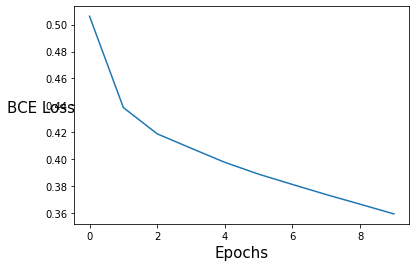

In [23]:
plt.plot(losses)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("BCE Loss", rotation=0, fontsize=15)
plt.show()

As we can see, our results are rather satisfying, but we can definately try more, in order to create a better model.

### $2^{nd}$ Model

We are going to expirement with different hyperparameters this time, by increasing the learning rate a bit, and by adding more neurons to both of our layers.

#### Definitions

In [24]:
epochs = 10
learning_rate = 0.003

input_shape = len(TEXT.vocab)

embedding_neuros = 128
hidden_neurons = 256

loss = torch.nn.BCELoss()
second_model = Sentiment_Model(input_shape, embedding_neuros, hidden_neurons)
optimizer = torch.optim.Adam(second_model.parameters(), lr=learning_rate)

# initialize the weights
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[ 1.4779,  0.9154, -0.0154,  ..., -1.5596,  0.7287,  0.4330],
        [-0.4040, -0.2261, -0.7617,  ..., -0.5244, -0.5593,  1.0435],
        [ 0.1189,  0.1525, -0.0821,  ..., -0.5751, -0.2667,  0.9212],
        ...,
        [ 0.0828, -1.1594,  0.5331,  ..., -0.5648,  0.0319, -0.5568],
        [-0.0382, -0.4149,  0.8220,  ...,  0.2949, -0.0117, -0.1182],
        [-0.1548,  1.0891, -0.3383,  ...,  0.6008, -1.5106,  0.5807]])

#### Training

In [25]:
losses = train(second_model, epochs, optimizer, train_iterator, loss)

Epoch:  0  loss:  0.8018  accuracy:  0.7458
Epoch:  1  loss:  0.4337  accuracy:  0.8005
Epoch:  2  loss:  0.4162  accuracy:  0.8086
Epoch:  3  loss:  0.4028  accuracy:  0.8147
Epoch:  4  loss:  0.39  accuracy:  0.8207
Epoch:  5  loss:  0.3768  accuracy:  0.8268
Epoch:  6  loss:  0.3643  accuracy:  0.8332
Epoch:  7  loss:  0.3509  accuracy:  0.8392
Epoch:  8  loss:  0.336  accuracy:  0.8467
Epoch:  9  loss:  0.3227  accuracy:  0.8531


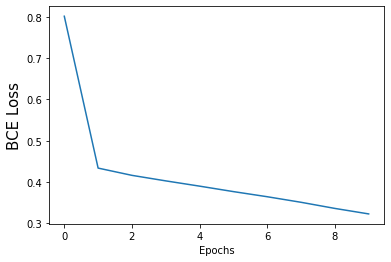

In [26]:
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("BCE Loss", fontsize=15)
plt.show()

## Comparison to the Logistic Regression Model

As we can see, the model that we developed using NNs with pre-trained vectors behave better than the LogReg model. That is mainly because of the pre-trained vector embeddings, as we saw that the TFIDF model behaved slightly worse than the LogReg.

Sentiment analysis is a rather simple task, linearly seperable, that does not require complex networks in order to be predicted. This is why such networks are used for more complex tasks. However, we can achieve good reults, without overfitting, by using a simple Feed Forward NN model, with only one hidden layer.

I did not experiment with more layers, as this would have made the model even more complex, and it most likely would have caused overfitting